In [210]:
# %load_ext autoreload
# %autoreload 2


In [71]:
import warnings
warnings.filterwarnings("ignore")

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from joblib import load

from logger import logger
# from utils import evaluate_binary, log_mlflow

In [73]:
from typing import Dict, Any, Tuple
from typing import Optional
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import numpy as np
from joblib import dump
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score
import yaml
from logger import logger


def plot_roc(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, plot_dir: str = None) -> str:
    """
    Plot the area under curve for the ROC curve.

    Args:
        y_true: Array of true y values
        y_pred: Array of predicted y values
        model_name: Name of model
        plot_dir: Directory to save plot in

    Returns:
        Output path of plot
    """
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    plt.grid()
    plt.plot(fpr, tpr, color='b')
    plt.title('ROC curve: {}'.format(model_name))
    Path(f"{plot_dir}\\plots").mkdir(parents=True, exist_ok=True)
    # Save figure
    if plot_dir:
        output_path = '{}\\plots\\roc_curve_{}.png'.format(plot_dir, model_name)
        plt.savefig(output_path)
        logger.info('ROC curve saved to: {}'.format(output_path))
        return output_path


def plot_precision_recall(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, plot_dir: str = None) -> str:
    """
    Plots the precision-recall curve.

    Args:
        y_true: Array of true y values
        y_pred: Array of predicted y values
        model_name: Name of model
        plot_dir: Directory to save plot in

    Returns:Ø
        Output path of plot
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    plt.figure(figsize=(15, 5))
    plt.grid()
    plt.plot(thresholds, precision[1:], color='r', label='Precision')
    plt.plot(thresholds, recall[1:], color='b', label='Recall')
    plt.gca().invert_xaxis()
    plt.legend()
    plt.title('Precision-recall curve: {}'.format(model_name))
    Path(f"{plot_dir}\\plots").mkdir(parents=True, exist_ok=True)
    # Save figure
    if plot_dir:
        output_path = '{}/plots/precision_recall_{}.png'.format(plot_dir, model_name)
        
        plt.savefig(output_path)
        logger.info('Precision-recall curve saved to: {}'.format(output_path))
        return output_path


def save_model(model: Any, model_name: str, model_dir: str) -> str:
    """
    Saves model in pickle format

    Args:
        model: Model binary
        model_name: Name of model
        model_dir: Directory to save model in

    Returns:
        Output path of model
    """
    Path(f"{model_dir}/models").mkdir(parents=True, exist_ok=True)
    output_path = '{}/models/{}.pickle'.format(model_dir, model_name)
    logger.info('Model saved to: {}'.format(output_path))
    dump(model, output_path)

    return output_path


def evaluate_binary(y_true: np.ndarray, y_pred: np.ndarray, threshold: float = 0.5) -> \
        Tuple[float, float, float, float]:
    """
    Returns binary evaluation metrics

    Args:
        y_true: Array of true y values
        y_pred: Array of predicted y values
        threshold: Threshold to convert probabilies to binary values (default=0.5)

    Returns:
        Metrics for AUC, recall, precision, and F1
    """
    y_pred_thresholded = np.where(y_pred > threshold, 1, 0)

    auc = roc_auc_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred_thresholded)
    precision = precision_score(y_true, y_pred_thresholded)
    f1 = f1_score(y_true, y_pred_thresholded)

    logger.info('AUC: {:.3f} | Recall: {:.3f} | Precision: {:.3f} | F1: {:.3f}'.format(auc, recall, precision, f1))
    return auc, recall, precision, f1


def save_metrics(auc,recall, precision,f1, metrics_dir: str, metrics_name:str)-> None:
    # Calculate metrics
    metrics = {}

    metrics["auc"] = float(auc)
    metrics["precision"] = float(precision)
    metrics["recall"] = float(recall)
    metrics["f1"] = float(f1)
    Path(f"{metrics_dir}/metrics").mkdir(parents=True, exist_ok=True)
    output_path = f"{metrics_dir}\\metrics\\{metrics_name}_mertics.yaml"
    logger.info('Model metrics to: {}'.format(output_path))
    with open(output_path, 'w+') as file:
        yaml.dump(metrics, file, default_flow_style=False)
        
def log_mlflow(run_params: Dict, model: Any, model_name: str, y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Logs result of model training and validation to mlflow

    Args:
        run_params: Dictionary containing parameters of run.
                    Expects keys for 'experiment', 'artifact_dir', 'iteration', and 'index.
        model: Model binary
        model_name: Name of model
        y_true: Array of true y values
        y_pred: Array of predicted y values

    Returns:
        None
    """
    mlflow.set_experiment(run_params['experiment'])

    auc, recall, precision, f1 = evaluate_binary(y_true, y_pred)
    
    save_metrics(auc,recall ,precision,f1, metrics_dir= run_params['artifact_dir'],metrics_name =model_name+ "_" +run_params["index"])

    roc_path = plot_roc(y_true, y_pred, '{} (auc = {:.2f})'.format(model_name, auc), run_params['artifact_dir'])
    pr_path = plot_precision_recall(y_true, y_pred,
                                    '{} prec= {:.2f} recall= {:.2f}'.format(model_name, precision, recall),
                                    run_params['artifact_dir'])
    model_path = save_model(model, model_name, run_params['artifact_dir'])
    print(model_path)
    with mlflow.start_run(run_name=run_params['iteration']):
        mlflow.log_param('index', run_params['index'])
        mlflow.log_param('model', model_name)
        mlflow.log_metric('auc', auc)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('f1', f1)
        mlflow.log_artifact(model_path)
        mlflow.log_artifact(roc_path)
        mlflow.log_artifact(pr_path)


In [74]:

def find_project_root() -> Optional[Path]:
    current = Path(".").resolve()
    
    while True:
        if (current / ".git").exists():
            return current
        
        if current.parent == current:
            print("WARNING: No .git dir found")
            return current
              
        current = current.parent
        

PROJECT_ROOT = find_project_root()
PROJECT_ROOT

WindowsPath('C:/Users/Harsha/Documents/ISB_AMPBA/Term5/FP2/GroupAssignment/fp2')

In [75]:
# Tag this cell as 'parameters'
# BASE
INDEX = 'SNP'
EXPERIMENT = 'stock_up_down'  # Name of experiment
RUN_NAME = 'initial_assessment'  # Name of iteration (that will show
ARTIFACT_DIR = PROJECT_ROOT / 'artifact_dir'  # Dir for notebook outputs where plots are saved

# Logestic Regression
FIT_INTERCEPT= False

# SVM
GAMMA=2
C_VALUE=1
PROBABILITY=True

# K-neighbour
N_NEIGHBORS = 5

# Gradient boosting Classifier
N_ESTIMATORS = 100

In [76]:
ARTIFACT_DIR

WindowsPath('C:/Users/Harsha/Documents/ISB_AMPBA/Term5/FP2/GroupAssignment/fp2/artifact_dir')

In [77]:
# Wrap all this is a parameter dict
run_params = {'experiment': EXPERIMENT,
              'iteration': RUN_NAME,
              'index': INDEX,
              'artifact_dir': ARTIFACT_DIR}

### Import data

In [78]:
df = pd.read_parquet(f'{PROJECT_ROOT}\\datadir\\datasets/US.parquet')
# df["stock_name"] = INDEX
df.head()

Unit of measure,Thousand Barrels per day (kb/d),TIME_PERIOD
0,5848,2002-01-01
1,5871,2002-02-01
2,5883,2002-03-01
3,5859,2002-04-01
4,5924,2002-05-01


### Data prep

In [79]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [80]:
df.sort_values(by='time_period', ascending=True, inplace=True)  # Have to sort ascending for rolling to work correctly

In [81]:
df['time_period'] =  pd.to_datetime(df['time_period'])

### Create basic features

In [82]:
df = df[['time_period', 'thousand_barrels_per_day_(kb/d)']].copy()

In [83]:
df['prev'] = df['thousand_barrels_per_day_(kb/d)'].shift(1)
df.head()

,time_period,thousand_barrels_per_day_(kb/d),prev
0,2002-01-01,5848,NaN
1,2002-02-01,5871,5848.0
2,2002-03-01,5883,5871.0
3,2002-04-01,5859,5883.0
4,2002-05-01,5924,5859.0


In [84]:
df['sma2'] = df['prev'].rolling(window=2).mean()
df['sma5'] = df['prev'].rolling(window=5).mean()
df['sma10'] = df['prev'].rolling(window=10).mean()
df['sma20'] = df['prev'].rolling(window=20).mean()
df.head()

,time_period,thousand_barrels_per_day_(kb/d),prev,sma2,sma5,sma10,sma20
0,2002-01-01,5848,NaN,NaN,NaN,NaN,NaN
1,2002-02-01,5871,5848.0,NaN,NaN,NaN,NaN
2,2002-03-01,5883,5871.0,5859.5,NaN,NaN,NaN
3,2002-04-01,5859,5883.0,5877.0,NaN,NaN,NaN
4,2002-05-01,5924,5859.0,5871.0,NaN,NaN,NaN


In [85]:
assert round(df['prev'].tail(5).mean(), 4) == round(df['sma5'].tail(1).item(), 4), 'Expected sma5 to be same as mean of past 5 items'
assert round(df['prev'].tail(10).mean(), 4) == round(df['sma10'].tail(1).item(), 4), 'Expected sma10 to be same as mean of past 10 items'
assert round(df['prev'].tail(20).mean(), 4) == round(df['sma20'].tail(1).item(), 4), 'Expected sma20 to be same as mean of past 20 items'

In [86]:
df['ema12'] = df['prev'].ewm(span=12, min_periods=12, adjust=False).mean()
df['ema26'] = df['prev'].ewm(span=26, min_periods=26, adjust=False).mean()

In [87]:
def difference(prev_price, moving_average):
    return (prev_price - moving_average) / prev_price

In [88]:
for col in ['sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']:
    df['{}_diff'.format(col)] = difference(df['prev'], df[col])

In [89]:
df.dropna(inplace=True)

In [90]:
df.shape

(225, 15)

In [91]:
# df.drop(columns=['date', 'open'], inplace=True)

### Create label

In [92]:
df['label'] = (df['thousand_barrels_per_day_(kb/d)'] > df['prev']).astype(int)
df.reset_index(inplace = True)
# df.drop(['index'], axis=1)


In [93]:
# Save FE
INDEX ="US"
Path(f"{PROJECT_ROOT}\\datadir/output").mkdir(parents=True, exist_ok=True)
df.to_csv(PROJECT_ROOT / "datadir/output" / '{}.csv'.format(INDEX), index=False)

In [94]:
df = df.drop(['index'], axis=1)
df

,time_period,thousand_barrels_per_day_(kb/d),prev,sma2,sma5,sma10,sma20,ema12,ema26,sma2_diff,sma5_diff,sma10_diff,sma20_diff,ema12_diff,ema26_diff,label
0,2004-03-01,5607,5556.0,5563.0,5580.0,5613.8,5647.80,5623.582048,5682.746116,-0.001260,-0.004320,-0.010403,-0.016523,-0.012164,-0.022812,1
1,2004-04-01,5526,5607.0,5581.5,5574.4,5601.2,5639.65,5621.030964,5677.135292,0.004548,0.005814,0.001034,-0.005823,-0.002502,-0.012509,0
2,2004-05-01,5548,5526.0,5566.5,5567.6,5583.7,5625.40,5606.410815,5665.940086,-0.007329,-0.007528,-0.010442,-0.017988,-0.014551,-0.025324,1
3,2004-06-01,5398,5548.0,5537.0,5561.4,5585.9,5632.25,5597.424536,5657.203783,0.001983,-0.002415,-0.006831,-0.015186,-0.008909,-0.019683,0
4,2004-07-01,5458,5398.0,5473.0,5527.0,5566.2,5634.00,5566.743838,5638.003503,-0.013894,-0.023898,-0.031160,-0.043720,-0.031260,-0.044462,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2022-07-01,11844,11797.0,11713.0,11622.2,11539.1,11338.55,11526.600443,11424.792970,0.007120,0.014817,0.021861,0.038862,0.022921,0.031551,1
221,2022-08-01,12002,11844.0,11820.5,11727.8,11631.7,11370.95,11575.431144,11455.845343,0.001984,0.009811,0.017925,0.039940,0.022676,0.032772,1
222,2022-09-01,12312,12002.0,11923.0,11788.0,11675.0,11412.65,11641.057122,11496.301243,0.006582,0.017830,0.027245,0.049104,0.030074,0.042135,1
223,2022-10-01,12381,12312.0,12157.0,11916.8,11727.2,11472.05,11744.279103,11556.723374,0.012589,0.032099,0.047498,0.068222,0.046111,0.061345,1


### Prepare dataset to store in parquet format

In [95]:
df.dtypes

time_period                        datetime64[ns]
thousand_barrels_per_day_(kb/d)             int64
prev                                      float64
sma2                                      float64
sma5                                      float64
sma10                                     float64
sma20                                     float64
ema12                                     float64
ema26                                     float64
sma2_diff                                 float64
sma5_diff                                 float64
sma10_diff                                float64
sma20_diff                                float64
ema12_diff                                float64
ema26_diff                                float64
label                                       int32
dtype: object

In [98]:

predictors_df = df.loc[:,df.columns!="label"]
target_df = df[["label","time_period"]]

datalen = len(df)
idslist= list(range(datalen))

record_ids = pd.DataFrame(data = idslist, columns = ["record_id"])

predictors_df = pd.concat(objs = [predictors_df, record_ids], axis = 1)
target_df = pd.concat(objs = [target_df, record_ids], axis = 1)

predictors_df.rename(columns = {'time_period':'event_timestamp','thousand_barrels_per_day_(kb/d)': 'oil_production'}, inplace = True)
target_df.rename(columns = {'time_period':'event_timestamp','thousand_barrels_per_day_(kb/d)': 'oil_production'}, inplace = True)

In [99]:
target_df.head()
target_df.dtypes

label                       int32
event_timestamp    datetime64[ns]
record_id                   int64
dtype: object

In [100]:
predictors_df.to_parquet(path=f"{PROJECT_ROOT}/datadir/output/predictors_df.parquet")
target_df.to_parquet(path=f"{PROJECT_ROOT}/datadir/output/target_df.parquet", index=False)

In [107]:
df = pd.read_parquet(f"{PROJECT_ROOT}/datadir/output/predictors_df.parquet")
df

,event_timestamp,oil_production,prev,sma2,sma5,sma10,sma20,ema12,ema26,sma2_diff,sma5_diff,sma10_diff,sma20_diff,ema12_diff,ema26_diff,record_id
0,2004-03-01,5607,5556.0,5563.0,5580.0,5613.8,5647.80,5623.582048,5682.746116,-0.001260,-0.004320,-0.010403,-0.016523,-0.012164,-0.022812,0
1,2004-04-01,5526,5607.0,5581.5,5574.4,5601.2,5639.65,5621.030964,5677.135292,0.004548,0.005814,0.001034,-0.005823,-0.002502,-0.012509,1
2,2004-05-01,5548,5526.0,5566.5,5567.6,5583.7,5625.40,5606.410815,5665.940086,-0.007329,-0.007528,-0.010442,-0.017988,-0.014551,-0.025324,2
3,2004-06-01,5398,5548.0,5537.0,5561.4,5585.9,5632.25,5597.424536,5657.203783,0.001983,-0.002415,-0.006831,-0.015186,-0.008909,-0.019683,3
4,2004-07-01,5458,5398.0,5473.0,5527.0,5566.2,5634.00,5566.743838,5638.003503,-0.013894,-0.023898,-0.031160,-0.043720,-0.031260,-0.044462,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2022-07-01,11844,11797.0,11713.0,11622.2,11539.1,11338.55,11526.600443,11424.792970,0.007120,0.014817,0.021861,0.038862,0.022921,0.031551,220
221,2022-08-01,12002,11844.0,11820.5,11727.8,11631.7,11370.95,11575.431144,11455.845343,0.001984,0.009811,0.017925,0.039940,0.022676,0.032772,221
222,2022-09-01,12312,12002.0,11923.0,11788.0,11675.0,11412.65,11641.057122,11496.301243,0.006582,0.017830,0.027245,0.049104,0.030074,0.042135,222
223,2022-10-01,12381,12312.0,12157.0,11916.8,11727.2,11472.05,11744.279103,11556.723374,0.012589,0.032099,0.047498,0.068222,0.046111,0.061345,223


In [102]:
# !pip install feast==0.23.3
predictors_df.head()
predictors_df.dtypes

event_timestamp    datetime64[ns]
oil_production              int64
prev                      float64
sma2                      float64
sma5                      float64
sma10                     float64
sma20                     float64
ema12                     float64
ema26                     float64
sma2_diff                 float64
sma5_diff                 float64
sma10_diff                float64
sma20_diff                float64
ema12_diff                float64
ema26_diff                float64
record_id                   int64
dtype: object

In [103]:
import feast
print(f"feast SDK version: {feast.__version__}")

feast SDK version: 0.27.1


In [108]:
from feast import FeatureStore
from feast.infra.offline_stores.file_source import SavedDatasetFileStorage

store = FeatureStore(repo_path=f'{PROJECT_ROOT}/feature_repo/')

entity_df = pd.read_parquet(path = f'{PROJECT_ROOT}/datadir/output/target_df.parquet')

training_data = store.get_historical_features(
entity_df = entity_df,
    features = [
        "predictors_df_feature_view:prev",
#         "predictors_df_feature_view:stock_name",
        "predictors_df_feature_view:sma2",
        "predictors_df_feature_view:sma5",
        "predictors_df_feature_view:sma10",
        "predictors_df_feature_view:sma20",
        "predictors_df_feature_view:ema12",
        "predictors_df_feature_view:ema26",
        "predictors_df_feature_view:sma2_diff",
        "predictors_df_feature_view:sma5_diff",
        "predictors_df_feature_view:sma10_diff",
        "predictors_df_feature_view:sma20_diff",
        "predictors_df_feature_view:ema12_diff",
        "predictors_df_feature_view:ema26_diff",
        "predictors_df_feature_view:oil_production",
        
               ]
)

### Genrate Training data
storage_path  = f'{PROJECT_ROOT}\\feature_repo\\data\\stock_dataset.parquet'
# Instantiate the Path class
obj = Path(storage_path)
obj.unlink(missing_ok=True)

dataset = store.create_saved_dataset(
from_=training_data,
    name = "stocks_dataset",
    storage = SavedDatasetFileStorage(storage_path)
)

In [109]:
# print(f'{PROJECT_ROOT}\\datadir\\output\\stock_dataset.parquet')
df = training_data.to_df()
df

,label,event_timestamp,record_id,prev,sma2,sma5,sma10,sma20,ema12,ema26,sma2_diff,sma5_diff,sma10_diff,sma20_diff,ema12_diff,ema26_diff,oil_production
0,1,2004-03-01 00:00:00+00:00,0,5556.0,5563.0,5580.0,5613.8,5647.80,5623.582048,5682.746116,-0.001260,-0.004320,-0.010403,-0.016523,-0.012164,-0.022812,5607
1,0,2004-04-01 00:00:00+00:00,1,5607.0,5581.5,5574.4,5601.2,5639.65,5621.030964,5677.135292,0.004548,0.005814,0.001034,-0.005823,-0.002502,-0.012509,5526
2,1,2004-05-01 00:00:00+00:00,2,5526.0,5566.5,5567.6,5583.7,5625.40,5606.410815,5665.940086,-0.007329,-0.007528,-0.010442,-0.017988,-0.014551,-0.025324,5548
3,0,2004-06-01 00:00:00+00:00,3,5548.0,5537.0,5561.4,5585.9,5632.25,5597.424536,5657.203783,0.001983,-0.002415,-0.006831,-0.015186,-0.008909,-0.019683,5398
4,1,2004-07-01 00:00:00+00:00,4,5398.0,5473.0,5527.0,5566.2,5634.00,5566.743838,5638.003503,-0.013894,-0.023898,-0.031160,-0.043720,-0.031260,-0.044462,5458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,1,2022-07-01 00:00:00+00:00,220,11797.0,11713.0,11622.2,11539.1,11338.55,11526.600443,11424.792970,0.007120,0.014817,0.021861,0.038862,0.022921,0.031551,11844
221,1,2022-08-01 00:00:00+00:00,221,11844.0,11820.5,11727.8,11631.7,11370.95,11575.431144,11455.845343,0.001984,0.009811,0.017925,0.039940,0.022676,0.032772,12002
222,1,2022-09-01 00:00:00+00:00,222,12002.0,11923.0,11788.0,11675.0,11412.65,11641.057122,11496.301243,0.006582,0.017830,0.027245,0.049104,0.030074,0.042135,12312
223,1,2022-10-01 00:00:00+00:00,223,12312.0,12157.0,11916.8,11727.2,11472.05,11744.279103,11556.723374,0.012589,0.032099,0.047498,0.068222,0.046111,0.061345,12381


In [110]:
df = training_data.to_df()
df = df.drop(['event_timestamp','record_id'], axis=1)

In [111]:
df.head()

,label,prev,sma2,sma5,sma10,sma20,ema12,ema26,sma2_diff,sma5_diff,sma10_diff,sma20_diff,ema12_diff,ema26_diff,oil_production
0,1,5556.0,5563.0,5580.0,5613.8,5647.80,5623.582048,5682.746116,-0.001260,-0.004320,-0.010403,-0.016523,-0.012164,-0.022812,5607
1,0,5607.0,5581.5,5574.4,5601.2,5639.65,5621.030964,5677.135292,0.004548,0.005814,0.001034,-0.005823,-0.002502,-0.012509,5526
2,1,5526.0,5566.5,5567.6,5583.7,5625.40,5606.410815,5665.940086,-0.007329,-0.007528,-0.010442,-0.017988,-0.014551,-0.025324,5548
3,0,5548.0,5537.0,5561.4,5585.9,5632.25,5597.424536,5657.203783,0.001983,-0.002415,-0.006831,-0.015186,-0.008909,-0.019683,5398
4,1,5398.0,5473.0,5527.0,5566.2,5634.00,5566.743838,5638.003503,-0.013894,-0.023898,-0.031160,-0.043720,-0.031260,-0.044462,5458


### Train-val split

In [112]:
# Keep most recent 20 days as validation set

In [113]:
validation_days = 20
train = df.iloc[:-validation_days].copy()
val = df.iloc[-validation_days:].copy()
logger.info('No. of days - Train: {}, Val: {}'.format(train.shape[0], val.shape[0]))

2023-02-16 10:05:32,098 - No. of days - Train: 205, Val: 20


### Basic visualizations

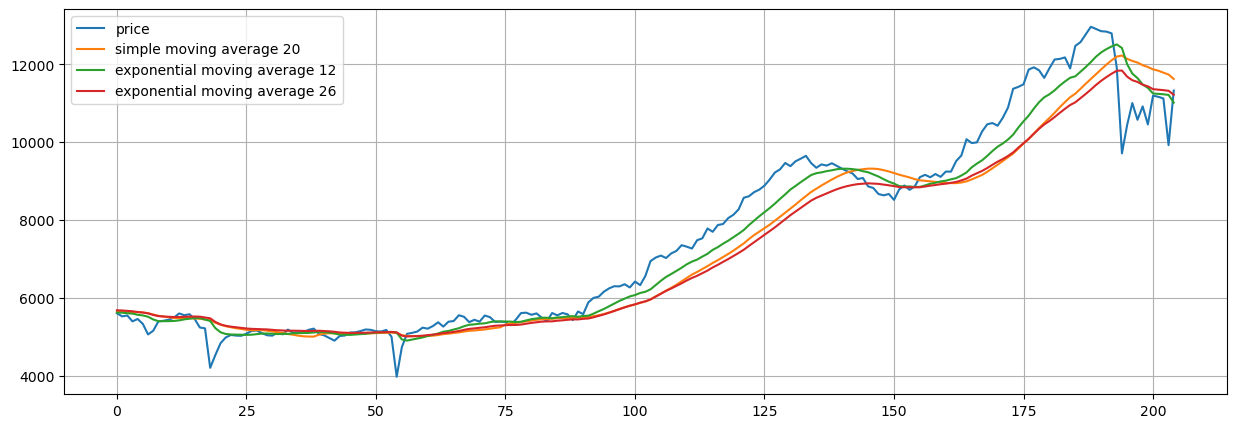

In [115]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(train['oil_production'], label='price')
plt.plot(train['sma20'], label='simple moving average 20')
plt.plot(train['ema12'], label='exponential moving average 12')
plt.plot(train['ema26'], label='exponential moving average 26')
plt.legend()

### Feature transformations

In [116]:
scaler = StandardScaler()

In [117]:
COLS_TO_SCALE = ['prev', 'sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']

In [118]:
scaler.fit(train[COLS_TO_SCALE])

StandardScaler()

In [119]:
train[COLS_TO_SCALE] = scaler.transform(train[COLS_TO_SCALE])
val[COLS_TO_SCALE] = scaler.transform(val[COLS_TO_SCALE])

### Linear regression coefficients

In [120]:
x_variables = '+'.join(list(train.columns[1:-1]))
logger.info('x variables: {}'.format(x_variables))

2023-02-16 10:05:42,936 - x variables: prev+sma2+sma5+sma10+sma20+ema12+ema26+sma2_diff+sma5_diff+sma10_diff+sma20_diff+ema12_diff+ema26_diff


In [121]:
results = smf.ols('oil_production ~ {}'.format(x_variables), data=train).fit()

In [122]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         oil_production   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1209.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):          1.12e-175
Time:                        10:05:52   Log-Likelihood:                -1440.1
No. Observations:                 205   AIC:                             2908.
Df Residuals:                     191   BIC:                             2955.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7340.1062     62.970    116.565      0.0

### Drop label col

In [124]:
train.drop(columns=['oil_production'], inplace=True)
val.drop(columns=['oil_production'], inplace=True)

### Logistic Regression Coefficients

In [125]:
y = train['label'].values
X = train.drop(columns=['label'])

In [126]:
X = add_constant(X)

In [127]:
logit = sm.Logit(y, X)

In [128]:
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.632388
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  205
Model:                          Logit   Df Residuals:                      191
Method:                           MLE   Df Model:                           13
Date:                Thu, 16 Feb 2023   Pseudo R-squ.:                 0.06036
Time:                        10:06:02   Log-Likelihood:                -129.64
converged:                       True   LL-Null:                       -137.97
Covariance Type:            nonrobust   LLR p-value:                    0.2155
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4219      0.475     -0.887      0.375      -1.354       0.510
prev          -1.7089      8.

### Train some basic models

In [129]:
y_train = train['label'].values
X_train = train.drop(columns='label').values

y_val = val['label'].values
X_val = val.drop(columns='label').values

In [130]:
#python program to check if a directory exists
import os
path = run_params["artifact_dir"]
# Check whether the specified path exists or not
isExist = os.path.exists(path)
isExist
# if not isExist:

#    # Create a new directory because it does not exist
#    os.makedirs(path)
#    print("The new directory is created!")

True

2023-02-16 10:06:09,080 - AUC: 0.515 | Recall: 0.000 | Precision: 0.000 | F1: 0.000
2023-02-16 10:06:09,082 - Model metrics to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir\metrics\Logistic_Regression_SNP_mertics.yaml
2023-02-16 10:06:09,204 - ROC curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir\plots\roc_curve_Logistic_Regression (auc = 0.52).png
2023-02-16 10:06:09,414 - Precision-recall curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/plots/precision_recall_Logistic_Regression prec= 0.00 recall= 0.00.png
2023-02-16 10:06:09,414 - Model saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/models/Logistic_Regression.pickle


C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/models/Logistic_Regression.pickle


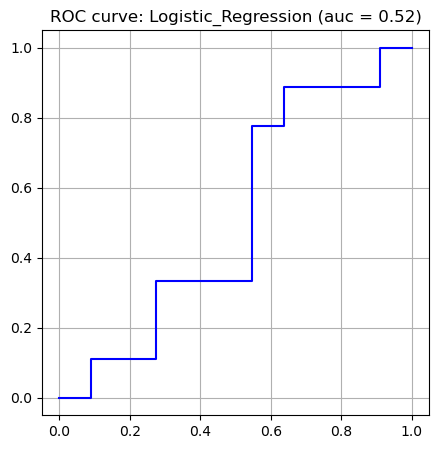

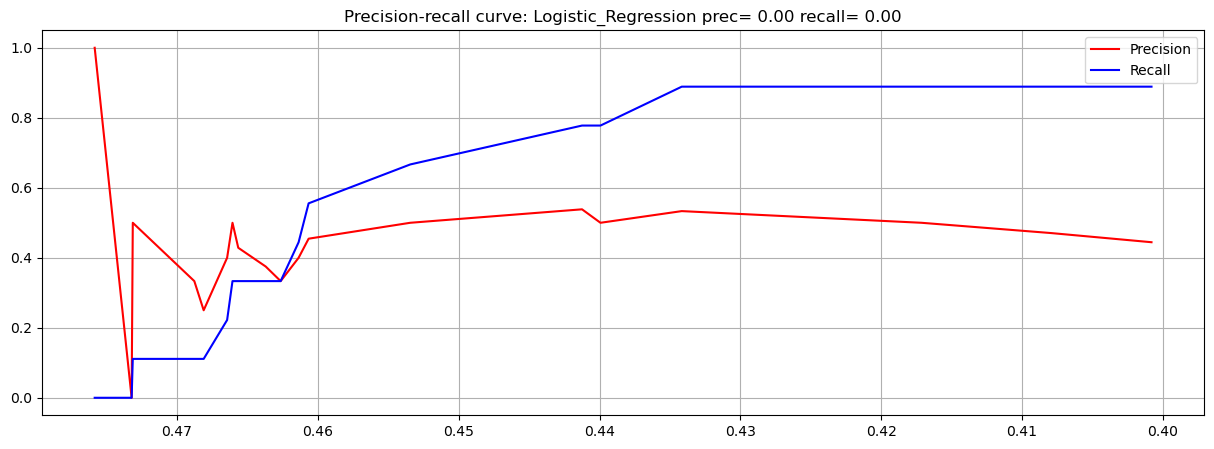

In [131]:
# Logistic regression
model_name = 'Logistic_Regression'
model = LogisticRegression(fit_intercept=FIT_INTERCEPT).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

2023-02-16 10:06:11,842 - AUC: 0.626 | Recall: 0.667 | Precision: 0.500 | F1: 0.571
2023-02-16 10:06:11,842 - Model metrics to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir\metrics\Support Vector Classifier_SNP_mertics.yaml
2023-02-16 10:06:11,970 - ROC curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir\plots\roc_curve_Support Vector Classifier (auc = 0.63).png
2023-02-16 10:06:12,182 - Precision-recall curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/plots/precision_recall_Support Vector Classifier prec= 0.50 recall= 0.67.png
2023-02-16 10:06:12,182 - Model saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/models/Support Vector Classifier.pickle


C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/models/Support Vector Classifier.pickle


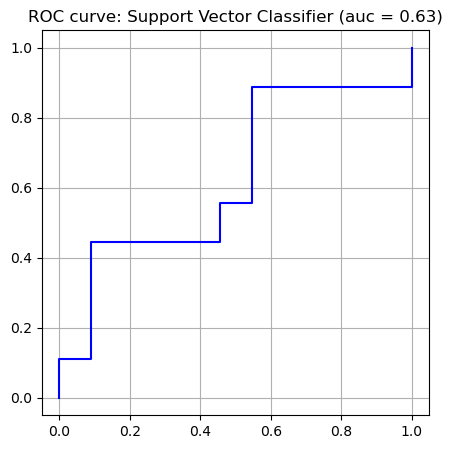

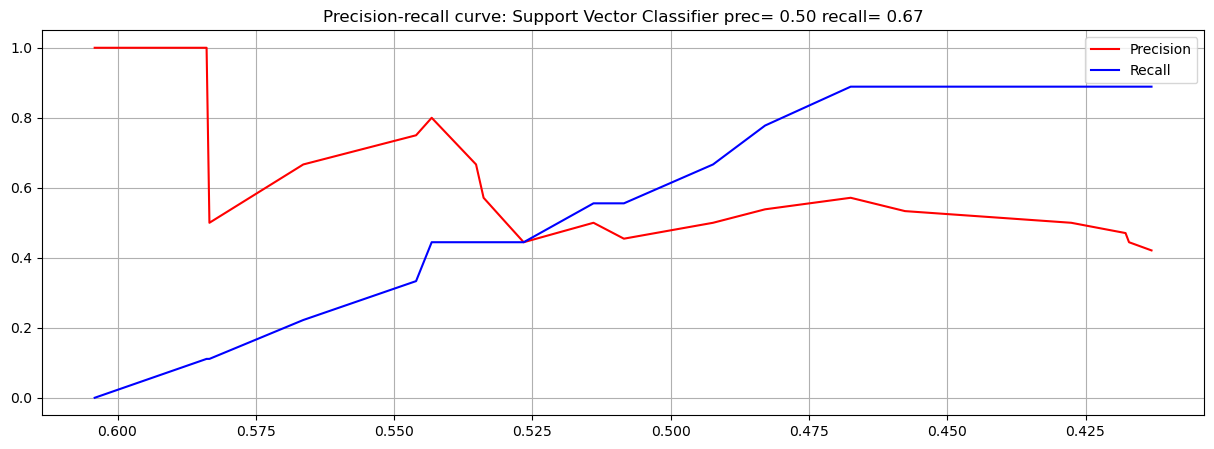

In [132]:
# Support vector classifier
model_name = 'Support Vector Classifier'
model = SVC(gamma=GAMMA, C=C_VALUE, probability=PROBABILITY).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)



2023-02-16 10:06:12,607 - AUC: 0.490 | Recall: 0.556 | Precision: 0.455 | F1: 0.500
2023-02-16 10:06:12,622 - Model metrics to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir\metrics\K-nearest Neighbours_SNP_mertics.yaml
2023-02-16 10:06:12,755 - ROC curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir\plots\roc_curve_K-nearest Neighbours (auc = 0.49).png
2023-02-16 10:06:12,954 - Precision-recall curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/plots/precision_recall_K-nearest Neighbours prec= 0.45 recall= 0.56.png
2023-02-16 10:06:12,954 - Model saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/models/K-nearest Neighbours.pickle


C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/models/K-nearest Neighbours.pickle


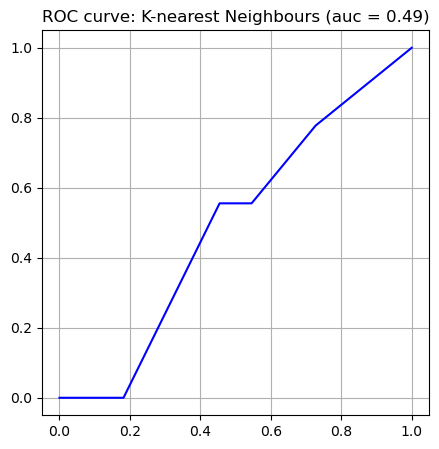

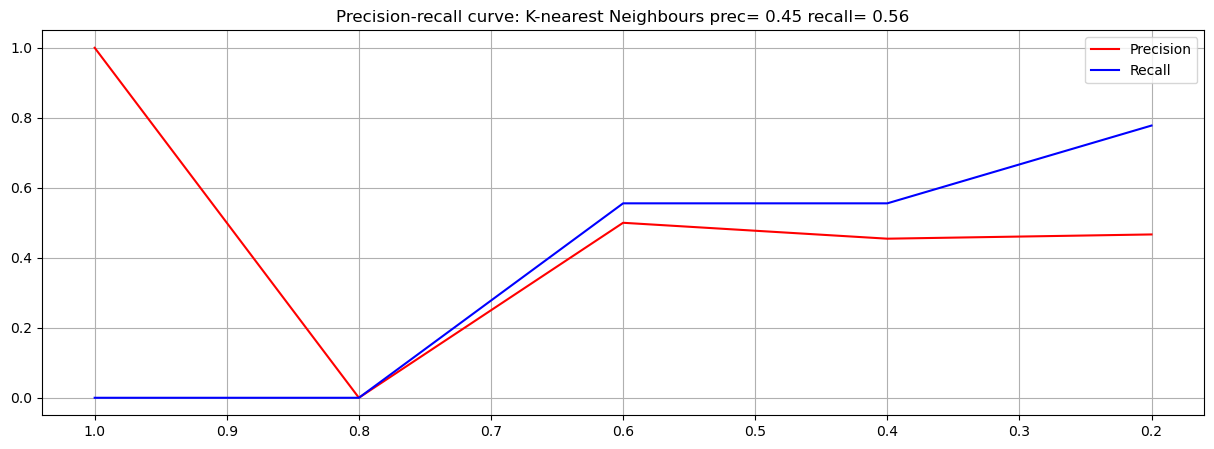

In [133]:
# K-neighbours
model_name = 'K-nearest Neighbours'
model = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)


2023-02-16 10:06:13,751 - AUC: 0.253 | Recall: 0.778 | Precision: 0.412 | F1: 0.538
2023-02-16 10:06:13,751 - Model metrics to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir\metrics\Gradient Boosting Machine_SNP_mertics.yaml
2023-02-16 10:06:13,871 - ROC curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir\plots\roc_curve_Gradient Boosting Machine (auc = 0.25).png
2023-02-16 10:06:14,053 - Precision-recall curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/plots/precision_recall_Gradient Boosting Machine prec= 0.41 recall= 0.78.png
2023-02-16 10:06:14,053 - Model saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/models/Gradient Boosting Machine.pickle


C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/models/Gradient Boosting Machine.pickle


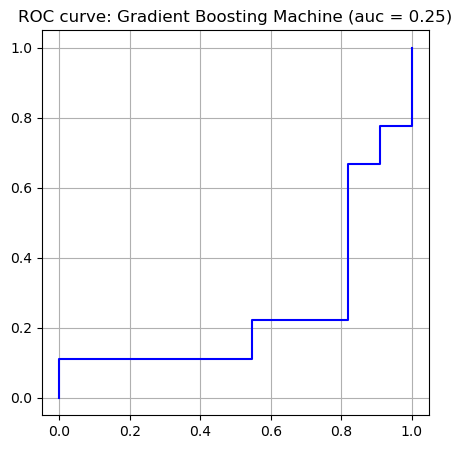

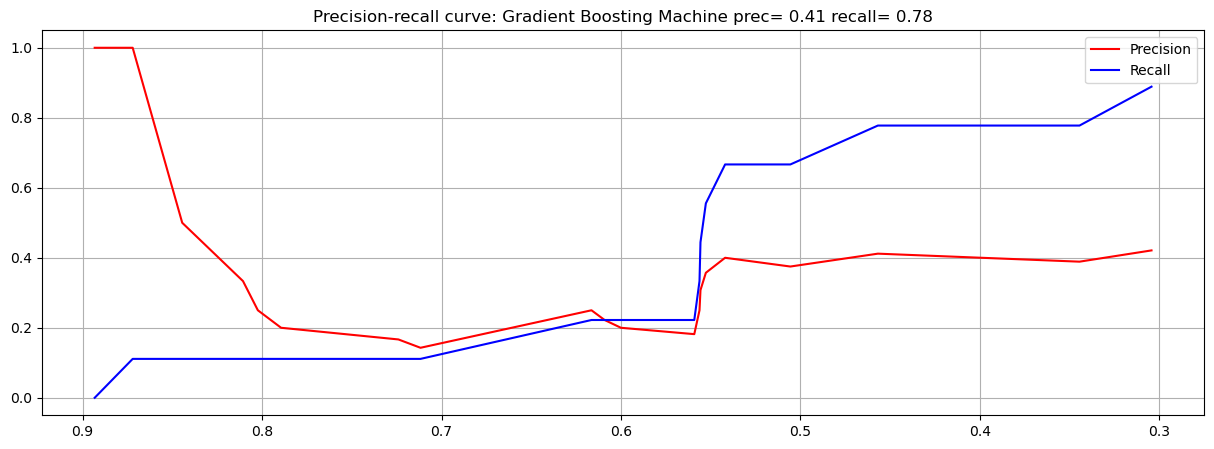

In [134]:
# Gradient Boosting
model_name = 'Gradient Boosting Machine'
model = GradientBoostingClassifier(n_estimators=N_ESTIMATORS).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

2023-02-16 10:06:14,568 - AUC: 0.505 | Recall: 0.667 | Precision: 0.545 | F1: 0.600
2023-02-16 10:06:14,568 - Model metrics to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir\metrics\Extra Trees_SNP_mertics.yaml
2023-02-16 10:06:14,689 - ROC curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir\plots\roc_curve_Extra Trees (auc = 0.51).png
2023-02-16 10:06:14,906 - Precision-recall curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/plots/precision_recall_Extra Trees prec= 0.55 recall= 0.67.png
2023-02-16 10:06:14,906 - Model saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/models/Extra Trees.pickle


C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\fp2\artifact_dir/models/Extra Trees.pickle


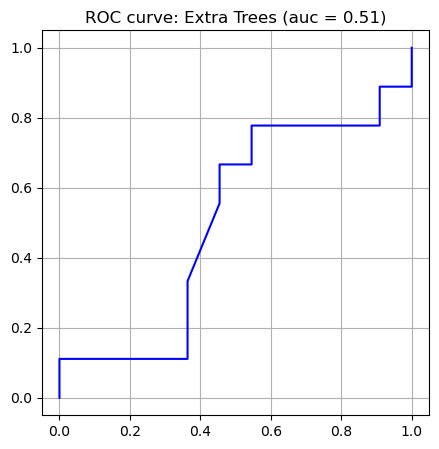

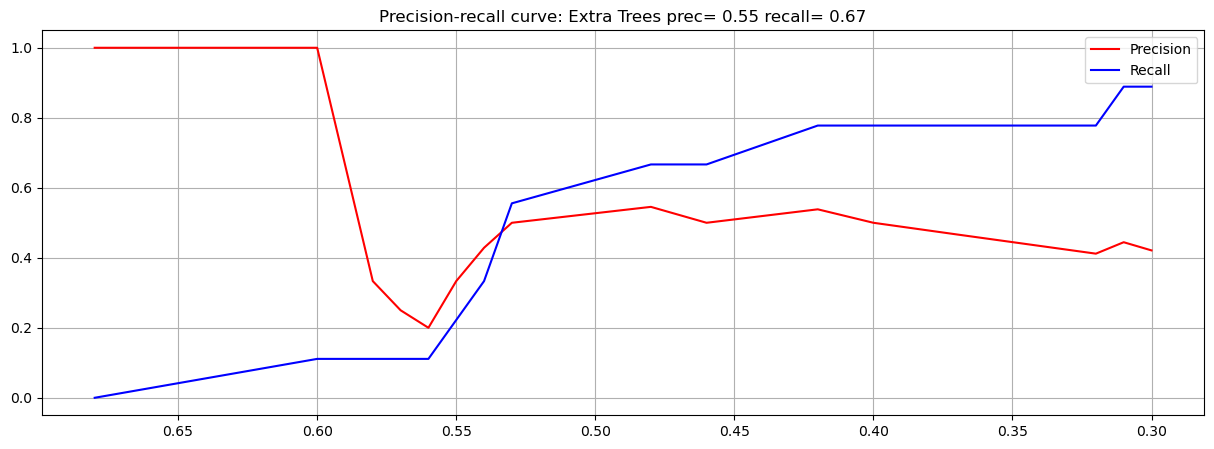

In [135]:
# Bagged trees
model_name = 'Extra Trees'
model = ExtraTreesClassifier().fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

### Test loading model

In [136]:
model_name = 'Support Vector Classifier'
check_model = load('{}/models/{}.pickle'.format(ARTIFACT_DIR, model_name))

In [137]:
check_model

SVC(C=1, gamma=2, probability=True)

In [138]:
pred = check_model.predict_proba(X_val)[:, 1]

In [139]:
evaluate_binary(y_val, pred)

2023-02-16 10:06:19,696 - AUC: 0.626 | Recall: 0.667 | Precision: 0.500 | F1: 0.571


(0.6262626262626263, 0.6666666666666666, 0.5, 0.5714285714285715)